<a href="https://colab.research.google.com/github/Czedros/CSE352-Machine-Learning-Assignments/blob/main/Agents/robot_vacuum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SBU CSE 352 - HW 1 -  Intelligent Agents: Reflex-Based Agents for the Vacuum-cleaner World

---

Name: Kay Zhang

I understand that my submission needs to be my own work: yes

## Instructions

Total Points: 100

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Only use standard packages (numpy, scipy, and built-in packages like random). Submit the completely rendered notebook as a HTML file.

## Introduction

In this assignment you will implement a simulator environment for an automatic vacuum cleaner robot, a set of different reflex-based agent programs, and perform a comparison study for cleaning a single room. Focus on the __cleaning phase__ which starts when the robot is activated and ends when the last dirty square in the room has been cleaned. Someone else will take care of the agent program needed to navigate back to the charging station after the room is clean.

## PEAS description of the cleaning phase

__Performance Measure:__ Each action costs 1 energy unit. The performance is measured as the sum of the energy units used to clean the whole room.

__Environment:__ A room with $n \times n$ squares where $n = 5$. Dirt is randomly placed on each square with probability $p = 0.2$. For simplicity, you can assume that the agent knows the size and the layout of the room (i.e., it knows $n$). To start, the agent is placed on a random square.

__Actuators:__ The agent can clean the current square (action `suck`) or move to an adjacent square by going `north`, `east`, `south`, or `west`.

__Sensors:__ Four bumper sensors, one for north, east, south, and west; a dirt sensor reporting dirt in the current square.  


## The agent program for a simple randomized agent

The agent program is a function that gets sensor information (the current percepts) as the arguments. The arguments are:

* A dictionary with boolean entries for the for bumper sensors `north`, `east`, `west`, `south`. E.g., if the agent is on the north-west corner, `bumpers` will be `{"north" : True, "east" : False, "south" : False, "west" : True}`.
* The dirt sensor produces a boolean.

The agent returns the chosen action as a string.

Here is an example implementation for the agent program of a simple randomized agent:  

In [72]:
import numpy as np

actions = ["north", "east", "west", "south", "suck"]

def simple_randomized_agent(bumpers, dirty):
    return np.random.choice(actions)

In [73]:
# define percepts (current location is NW corner and it is dirty)
bumpers = {"north" : True, "east" : False, "south" : False, "west" : True}
dirty = True

# call agent program function with percepts and it returns an action
simple_randomized_agent(bumpers, dirty)

'west'

__Note:__ This is not a rational intelligent agent. It ignores its sensors and may bump into a wall repeatedly or not clean a dirty square. You will be asked to implement rational agents below.

## Simple environment example

We implement a simple simulation environment that supplies the agent with its percepts.
The simple environment is infinite in size (bumpers are always `False`) and every square is always dirty, even if the agent cleans it. The environment function returns a performance measure which is here the number of cleaned squares (since the room is infinite and all squares are constantly dirty, the agent can never clean the whole room as required in the PEAS description above). The energy budget of the agent is specified as `max_steps`.

In [74]:
def simple_environment(agent, max_steps, verbose = True):
    num_cleaned = 0

    for i in range(max_steps):
        dirty = True
        bumpers = {"north" : False, "south" : False, "west" : False, "east" : False}

        action = agent(bumpers, dirty)
        if (verbose): print("step", i , "- action:", action)

        if (action == "suck"):
            num_cleaned = num_cleaned + 1

    return num_cleaned



Do one simulation run with a simple randomized agent that has enough energy for 20 steps.

In [75]:
simple_environment(simple_randomized_agent, max_steps = 20)

step 0 - action: suck
step 1 - action: west
step 2 - action: south
step 3 - action: north
step 4 - action: suck
step 5 - action: east
step 6 - action: south
step 7 - action: east
step 8 - action: north
step 9 - action: north
step 10 - action: west
step 11 - action: north
step 12 - action: east
step 13 - action: south
step 14 - action: east
step 15 - action: west
step 16 - action: suck
step 17 - action: north
step 18 - action: north
step 19 - action: north


3

# Tasks

## General [10 Points]

1. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design, for example. If it makes your code more simple objects are okay, but try to keep the code as simple as possible.
2. You notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
3. Document your code. Add a short discussion of how your implementation works and your design choices.


## Task 1: Implement a simulation environment [20 Points]

The simple environment above is not very realistic. Your environment simulator needs to follow the PEAS description from above. It needs to:

* Initialize the environment by storing the state of each square (clean/dirty) and making some dirty. ([Help with random numbers and arrays in Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/random_numbers_and_arrays.ipynb))
* Keep track of the agent's position.
* Call the agent function repeatedly and provide the agent function with the sensor inputs.  
* React to the agent's actions. E.g, by removing dirt from a square or moving the agent around unless there is a wall in the way.
* Keep track of the performance measure. That is, track the agent's actions until all dirty squares are clean and count the number of actions it takes the agent to complete the task.

The easiest implementation for the environment is to hold an 2-dimensional array to represent if squares are clean or dirty and to call the agent function in a loop until all squares are clean or a predefined number of steps have been reached (i.e., the robot runs out of energy).

The simulation environment should be a function like the `simple_environment()` and needs to work with the simple randomized agent program from above. **Use the same environment for all your agent implementations in the tasks below.**

*Note on debugging:* Debugging is difficult. Make sure your environment prints enough information when you use `verbose = True`. Also, implementing a function that the environment can use to displays the room with dirt and the current position of the robot at every step is very useful.  

In [76]:
import numpy as np
import random

def vacuum_environment(agent, room_size=(5,5), dirt_prob=0.2, max_steps=100, verbose=False):
    """
    Params:
        agent (function): The vacuum agent function.
        room_size (tuple): Size of the room as (rows, cols).
        dirt_prob (float): Chance of each position starting as dirty.
        max_steps (int): Maximum number of steps.
        verbose (bool): If True, prints each step of the simulation.

    Returns:
        int: Total energy (actions) used to clean the room.
    """

    # Instantiates the room via np.random.choice, slecting between "Clean" and "Dirty" (0 and 1 repectively)
    room = np.random.choice([0, 1], size=room_size, p=[1-dirt_prob, dirt_prob])


    agent_pos = [random.randint(0, room_size[0]-1), random.randint(0, room_size[1]-1)]


    steps = 0

    def print_room():
        """Prints the room grid with the agent's position."""
        for i in range(room_size[0]):
            row = ''
            for j in range(room_size[1]):
                if [i, j] == agent_pos:
                    row += 'A '  # Agent
                elif room[i, j] == 1:
                    row += '* '  # Dirt
                else:
                    row += '. '  # Clean
            print(row)
        print()

    # Simulation loop
    while np.any(room == 1) and steps < max_steps:
        bumpers = {
            "north": agent_pos[0] == 0,
            "south": agent_pos[0] == room_size[0] - 1,
            "west": agent_pos[1] == 0,
            "east": agent_pos[1] == room_size[1] - 1
        }
        dirty = room[agent_pos[0], agent_pos[1]] == 1

        action = agent(bumpers, dirty) # Agent decides action
        # Process agent action
        if action == "suck":
            room[agent_pos[0], agent_pos[1]] = 0 # Clean current square
        elif action == "north" and not bumpers["north"]:
            agent_pos[0] -= 1
        elif action == "south" and not bumpers["south"]:
            agent_pos[0] += 1
        elif action == "west" and not bumpers["west"]:
            agent_pos[1] -= 1
        elif action == "east" and not bumpers["east"]:
            agent_pos[1] += 1

        steps += 1
        if verbose: # Prints actions individually if verbose
            print(f"Step {steps}: Action - {action}")
            print_room()

    return steps # Return total steps

## Task 2:  Implement a simple reflex agent [10 Points]

The simple reflex agent randomly walks around but reacts to the bumper sensor by not bumping into the wall and to dirt with sucking. Implement the agent program as a function.

_Note:_ Agents cannot directly use variable in the environment. They only gets the percepts as the arguments to the agent function.

In [77]:
# Simple Reflex Agent

def simple_reflex_agent(bumpers, dirty):
    """
    A simple reflex agent that reacts to its sensors.
    - Sucks if the square is dirty.
    - Moves randomly but avoids walls.
    - default action (if no other available) is suck.
    """
    if dirty:
        return "suck"

    possible_moves = [action for action in ["north", "east", "west", "south"] if not bumpers[action]]
    return random.choice(possible_moves) if possible_moves else "suck"

## Task 3: Implement a model-based reflex agent [20 Points]

Model-based agents use a state to keep track of what they have done and perceived so far. Your agent needs to find out where it is located and then keep track of its current location. You also need a set of rules based on the state and the percepts to make sure that the agent will clean the whole room. For example, the agent can move to a corner to determine its location and then it can navigate through the whole room and clean dirty squares.

Describe how you define the __agent state__ and how your agent works before implementing it. ([Help with implementing state information on Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb))

In [111]:
# The agent state is defined by the following
# Agent's Current Position: The agent's current location in the room.
# Room Layout: A map of the room, tracking every square
# Unvisited: Squares that have not been visited by the agent
# Visited: Squares already visited by the agent.
# Target: Square that the agent is going to move towards.

# My Model Based Agent will follow Three primary rules, that being:
# - Start by moving towards the top left corner (defined as 0,0) using its bumpers to know if it has reached that location.

# - Move to an adjacent square that is not in the visited List.

# - Continue in that direction until it reaches the wall, cleaning any dirty squares it stands on, then choose another direction.

# - If no options available, move towards a random "unvisited" square.

# - We define this by a square that is in the room layout, but not in the visited list, selected by random

In [134]:
import random

def create_model_based_agent(room_size):
    """
    Creates a model-based reflex agent that tracks its position and visited squares.

    Args:
        room_size(tuple): The dimensions of the room in (rows, cols).

    Returns:
        Agent(function): The agent function that takes bumpers and dirty as inputs.
    """

    localized = False   # Since we do not know the actual board, we need to "calibrate" the vaccuum by putting it to the (0,0) position
    current_pos = None  # Tracks (row, col) the robot is in
    visited = set()     # Tiles that the robot has visited
    unvisited = set((i, j) for i in range(room_size[0]) for j in range(room_size[1])) # Tiles that the robot has not visited
    target = None    # Tool for "pathfinding"

    def agent(bumpers, dirty):
        nonlocal localized, current_pos, visited, unvisited, target

        # Localization (Getting the robot to a corner)
        if not localized:
            if not bumpers['north']:
                return 'north'  # Move north to reach top wall
            elif not bumpers['west']:
                return 'west'   # Move west to reach left wall
            else:
                # Now at (0,0), initialize state
                localized = True
                current_pos = (0, 0)
                visited.add(current_pos)
                unvisited.discard(current_pos)

        # Update if it has visited the tile
        if current_pos not in visited:
            visited.add(current_pos)
            unvisited.discard(current_pos)

        # Action (Suck if dirty)
        if dirty:
            return 'suck'

        # Movement (Adds to adjacent all valid moves for the robot)
        adjacent = []
        if not bumpers['north']:
            adjacent.append(('north', (current_pos[0]-1, current_pos[1])))
        if not bumpers['east']:
            adjacent.append(('east', (current_pos[0], current_pos[1]+1)))
        if not bumpers['south']:
            adjacent.append(('south', (current_pos[0]+1, current_pos[1])))
        if not bumpers['west']:
            adjacent.append(('west', (current_pos[0], current_pos[1]-1)))

        # Filter adjacent to find unvisited cells
        unvisited_adjacent = [(action, pos) for action, pos in adjacent if pos in unvisited]

        if unvisited_adjacent:
            # Choose a random unvisited adjacent cell
            action, new_pos = random.choice(unvisited_adjacent)
            current_pos = new_pos
            return action

        if not unvisited:
            return 'suck'  # All squares visited, start sucking.

        # If no Adjacent Unvisited: Move Towards Random Unvisited Square

        # Select a random target from unvisited
        target_pos = random.choice(list(unvisited))

        # Calculate direction to target
        dr = target_pos[0] - current_pos[0]
        dc = target_pos[1] - current_pos[1]

        # Gets the position
        if dr != 0:
            desired_dir = 'north' if dr < 0 else 'south'
            if not bumpers[desired_dir]:
                # Update current_pos and return direction
                current_pos = (
                    current_pos[0] - 1 if desired_dir == 'north' else current_pos[0] + 1,
                    current_pos[1]
                )
                return desired_dir

        # Then prioritize column movement (east/west)
        if dc != 0:
            desired_dir = 'east' if dc > 0 else 'west'
            if not bumpers[desired_dir]:
                # Update current_pos and return direction
                current_pos = (
                    current_pos[0],
                    current_pos[1] + 1 if desired_dir == 'east' else current_pos[1] - 1
                )
                return desired_dir

        # If direct path blocked, choose any valid move
        possible_moves = [action for action, _ in adjacent]
        if possible_moves:
            action = random.choice(possible_moves)
            # Update current_pos based on action
            if action == 'north':
                current_pos = (current_pos[0]-1, current_pos[1])
            elif action == 'south':
                current_pos = (current_pos[0]+1, current_pos[1])
            elif action == 'east':
                current_pos = (current_pos[0], current_pos[1]+1)
            else:
                current_pos = (current_pos[0], current_pos[1]-1)
            return action

        # No possible moves (default)
        return 'suck'

    return agent

## Task 4: Simulation study [30 Points]

Compare the performance (the performance measure is defined in the PEAS description above) of the agents using  environments of different size. E.g., $5 \times 5$, $10 \times 10$ and
$100 \times 100$. Use 100 random runs for each with 100000 max steps. Present the results using tables and graphs. Discuss the differences between the agents.
([Help with charts and tables in Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/charts_and_tables.ipynb))

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Define agents, room sizes, and parameters
agents = ['simple_randomized', 'simple_reflex', 'model_based']
room_sizes = [(5, 5), (10, 10), (100, 100)]
dirt_prob = 0.2
max_steps = 100000
num_runs = 100

# Store results
results = []

# Run simulations
for room_size in tqdm(room_sizes, desc="Room Sizes"):
    rows, cols = room_size
    for agent_name in tqdm(agents, desc="Agents", leave=False):
        for run in tqdm(range(num_runs), desc="Runs", leave=False):
            # Initialize agent, and name them for data collecting purposes
            if agent_name == 'simple_randomized':
                agent = simple_randomized_agent
            elif agent_name == 'simple_reflex':
                agent = simple_reflex_agent
            else:
                agent = create_model_based_agent(room_size)

            # Run environment
            steps = vacuum_environment(
                agent,
                room_size=room_size,
                dirt_prob=dirt_prob,
                max_steps=max_steps,
                verbose=False
            )
            results.append({
                'agent': agent_name,
                'room_size': f"{rows}x{cols}",
                'steps': steps
            })

# Convert results to DataFrame
df = pd.DataFrame(results)

# Compute statistics (THANK GOD FOR AMS 315)
stats = df.groupby(['agent', 'room_size']).agg(
    mean_steps=('steps', 'mean'),
    median_steps=('steps', 'median'),
    std_steps=('steps', 'std'),
    success_rate=('steps', lambda x: (x < max_steps).mean())
).reset_index()

print(stats.to_markdown(index=False))


Agents:   0%|          | 0/3 [00:00<?, ?it/s]

Runs:   0%|          | 0/100 [00:00<?, ?it/s]

Runs:   9%|▉         | 9/100 [00:00<00:01, 84.10it/s]

Runs:  19%|█▉        | 19/100 [00:00<00:00, 91.16it/s]

Runs:  29%|██▉       | 29/100 [00:00<00:00, 90.76it/s]

Runs:  42%|████▏     | 42/100 [00:00<00:00, 103.58it/s]

Runs:  53%|█████▎    | 53/100 [00:00<00:00, 94.21it/s] 

Runs:  63%|██████▎   | 63/100 [00:00<00:00, 94.69it/s]

Runs:  74%|███████▍  | 74/100 [00:00<00:00, 92.78it/s]

Runs:  87%|████████▋ | 87/100 [00:00<00:00, 96.02it/s]

Runs:  99%|█████████▉| 99/100 [00:01<00:00, 100.38it/s]

                                                       
Agents:  33%|███▎      | 1/3 [00:01<00:02,  1.05s/it]

Runs:   0%|          | 0/100 [00:00<?, ?it/s]

                                             

Runs:   0%|          | 0/100 [00:00<?, ?it/s]

                                             
Agents:   0%|          | 0/3 [00:00<?, ?it/s]

Runs:   0%|          | 0/100 [00:00<?, ?it/s]

Runs:   

| agent             | room_size   |   mean_steps |   median_steps |   std_steps |   success_rate |
|:------------------|:------------|-------------:|---------------:|------------:|---------------:|
| model_based       | 100x100     |    100000    |       100000   |     0       |              0 |
| model_based       | 10x10       |       187.03 |          181   |    43.0277  |              1 |
| model_based       | 5x5         |        34.08 |           34   |     9.80587 |              1 |
| simple_randomized | 100x100     |    100000    |       100000   |     0       |              0 |
| simple_randomized | 10x10       |      3065.47 |         2809.5 |  1241.91    |              1 |
| simple_randomized | 5x5         |       418.56 |          371.5 |   240.796   |              1 |
| simple_reflex     | 100x100     |    100000    |       100000   |     0       |              0 |
| simple_reflex     | 10x10       |       961.99 |          887.5 |   456.008   |              1 |
| simple_r

Fill out the following table with the average performance measure for 100 random runs (you may also create this table with code):

| Size     | Randomized Agent | Simple Reflex Agent | Model-based Reflex Agent |
|----------|------------------|---------------------|--------------------------|
| 5x5     |418.56 |119.99 |34.08 |
| 10x10   |3067.47 |961.99 |187.03 |
| 100x100 |10000 |10000 |10000 |

Add charts to compare the performance of the different agents.

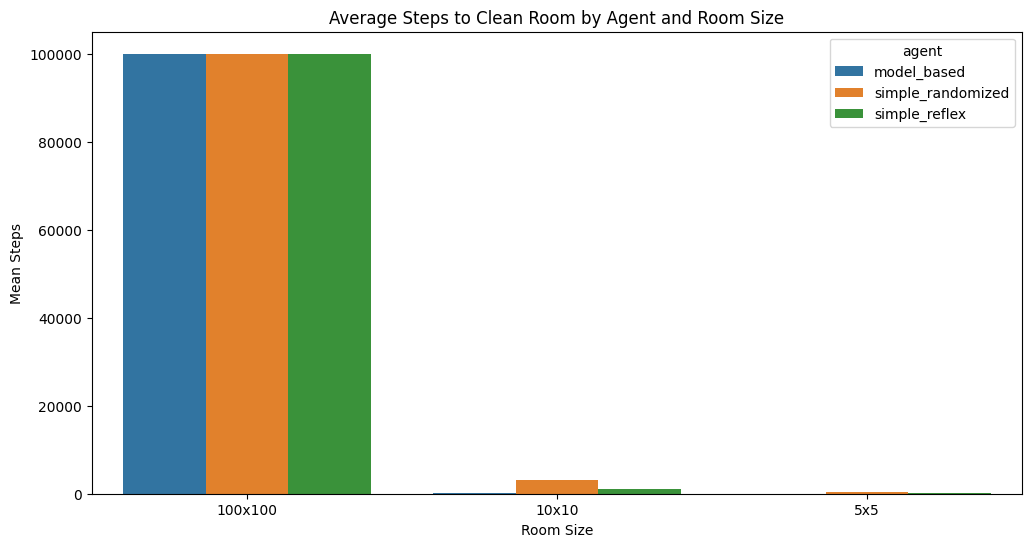

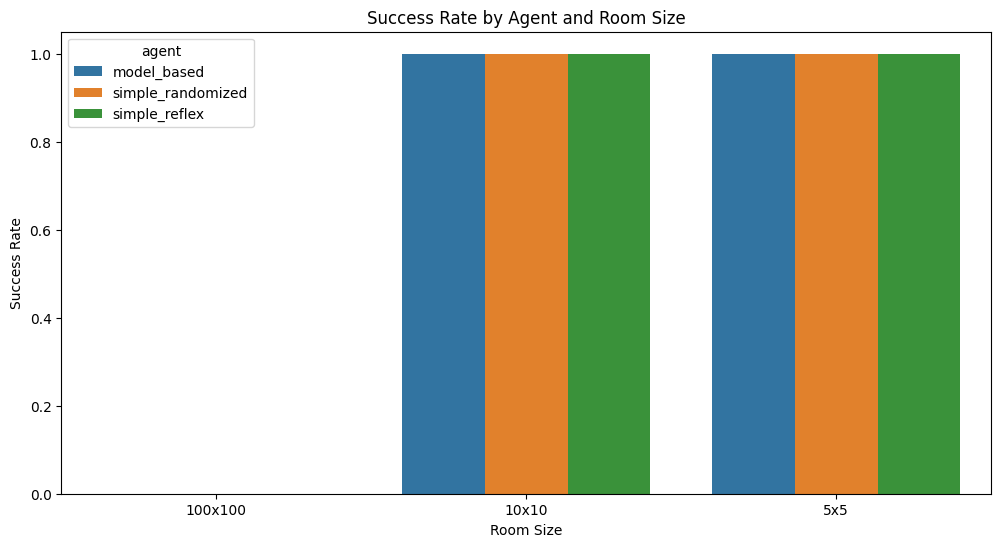

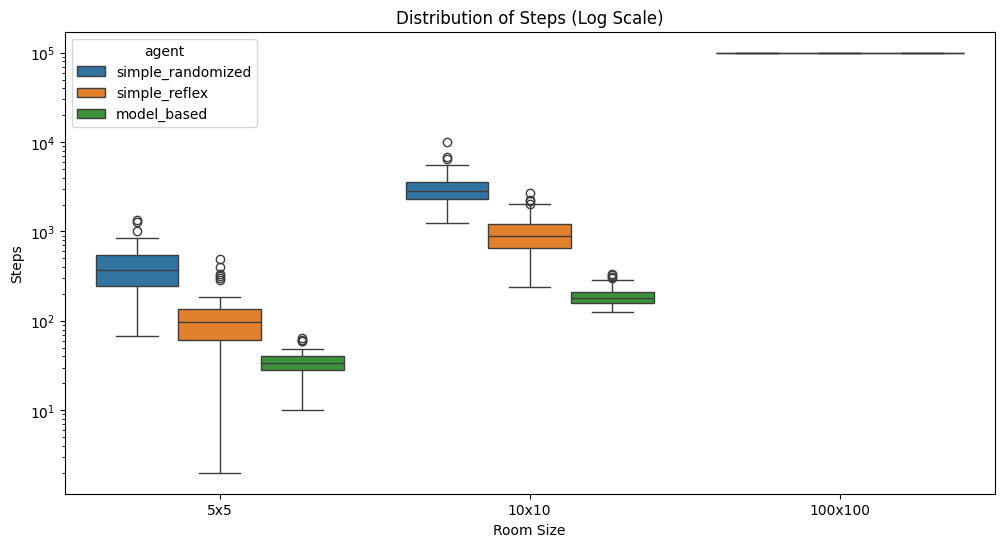

In [154]:
# Your graphs and discussion of the results goes here (THANK GOD FOR AMS 315)


# Bar Plot for Average Steps
plt.figure(figsize=(12, 6))
sns.barplot(data=stats, x='room_size', y='mean_steps', hue='agent')
plt.title('Average Steps to Clean Room by Agent and Room Size')
plt.ylabel('Mean Steps')
plt.xlabel('Room Size')
plt.show()

# Bar Plot for Success Rate
plt.figure(figsize=(12, 6))
sns.barplot(data=stats, x='room_size', y='success_rate', hue='agent')
plt.title('Success Rate by Agent and Room Size')
plt.ylabel('Success Rate')
plt.xlabel('Room Size')
plt.show()

# Bar Plot for Step Distribution
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='room_size', y='steps', hue='agent')
plt.yscale('log')
plt.title('Distribution of Steps (Log Scale)')
plt.ylabel('Steps')
plt.xlabel('Room Size')
plt.show()


#Discussion:
# The simple Model Based is significantly faster than the simple reflex and simple randomized in terms of energy spent.

# Evidently, random is worst as it wastes actions due to performing "valueless actions" (moving into walls, sucking clean tiles)

# Simple reflex is better as it no longer performs valueless actions, but still moves aimlessly, requiring luck for it to reach the finale.

# The Model based is most efficient, having some logic guiding its movement
# However, the Model based is still not as efficient as the simple "go to each tile once in sequence" as it
# Though this is by design, as the model I made is more efficient going into environments with obstacles and non-square/hexagonal environments.

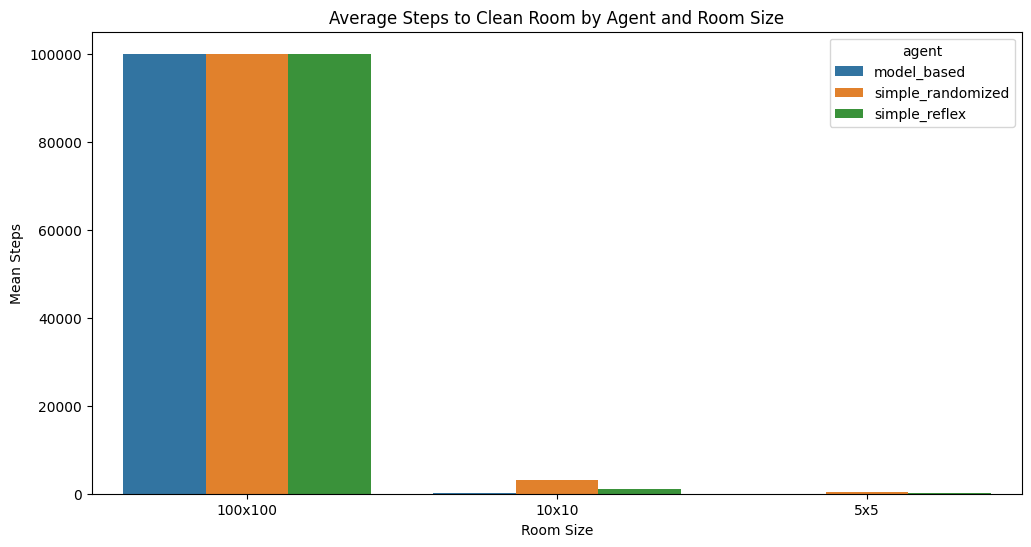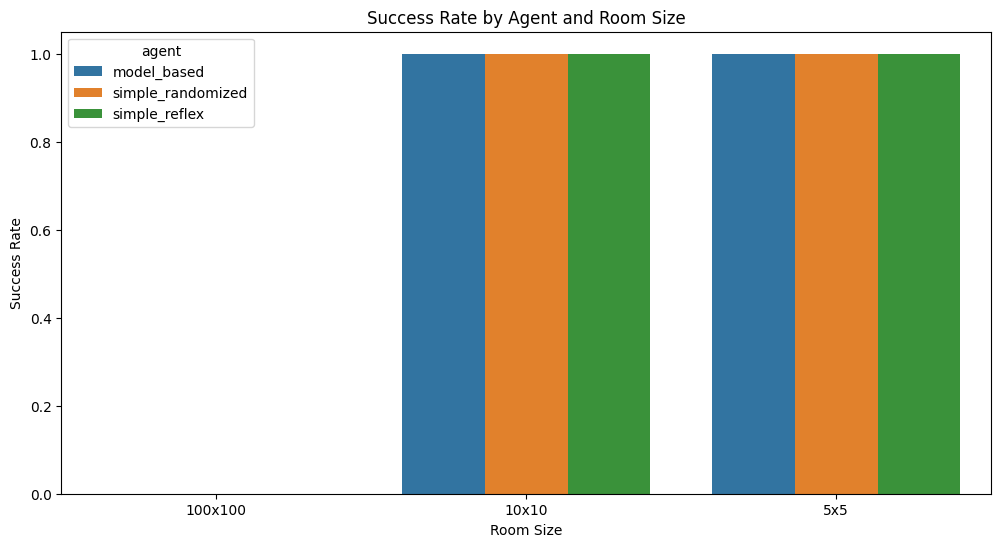

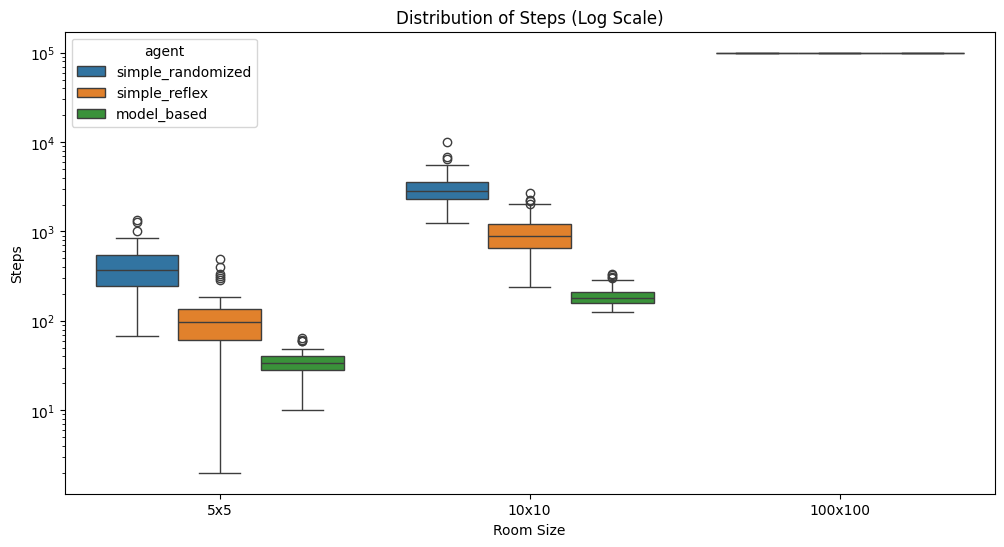

## Task 5: Robustness of the agent implementations [10 Points]

Describe how **your agent implementations** will perform

* if it is put into a rectangular room with unknown size,
* if the cleaning area can have an irregular shape (e.g., a hallway connecting two rooms), or
* if the room contains obstacles (i.e., squares that it cannot pass through and trigger the bumper sensors).

In [64]:
# For the 3 agents, they will perform relatively differently depending on the situation.
#
#
# For the Random agent
#
# if it is put into a rectangular room with unknown size,
#  - The agent would perform poorly, having an unknown upper limit as it wastes actions
#
# if the cleaning area can have an irregular shape (e.g., a hallway connecting two rooms), or
#  - The agent would perform poorly as well, as it bumps into walls and may not even head towards the "hallway"
#
#
# if the room contains obstacles (i.e., squares that it cannot pass through and trigger the bumper sensors).
#  - The agent would perform poorly once more, as it does not use its bumpers, it will may repeat already performed actions
#  - However, this would not be any different from how poorly it performs in other situations
#
# For the Simple Agent:
#
# if it is put into a rectangular room with unknown size,
#  - The agent would perform better than the random once more, with a variable amount of time to clean up the room
#  - This is because it has bumpers to not walk into the wall and would therefore not suck nothing and walk into walls.
#
# if the cleaning area can have an irregular shape (e.g., a hallway connecting two rooms), or
# - The agent would perform decently, as it won't walk into walls, but still have issues walking into the hallway from the room due to not having
#   pathfinding
#
# if the room contains obstacles (i.e., squares that it cannot pass through and trigger the bumper sensors).
#  - The agent would perform better than the random agent, as with the bumpers, it will not "waste" moves
#  - However, due to moving randomly, it still isn't highly efficient.
#
# For the Model based agent
#
# if it is put into a rectangular room with unknown size,
#  - The agent would well, having an approximate max number of steps being nxm where n and m are the length and width of the room respectively
#  - This is because the agent will try to move towards every square only once with minimum amount of repeats.
#
# if the cleaning area can have an irregular shape (e.g., a hallway connecting two rooms), or
#  - The agent would fare really well, as it travels to hexes unvisited and would easily go between the hallways.
#
# if the room contains obstacles (i.e., squares that it cannot pass through and trigger the bumper sensors).
#  - The agent would do well, as it has a pathing system that prevents repeating moves and heading to corners first.
#  - However it will be slow still due to not optimizing its pathfinding.
#



---
Assignment adapted from [Michael Hahsler](https://github.com/mhahsler/CS7320-AI) under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/deed.en) license.
